# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계1 : 데이터 탐색

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * 한국어 처리
>> * [konlpy - 한국어 처리 라이브러리](https://konlpy.org/ko/latest/)
>> * [한국어 품사 태그 비교표](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)
>> * [한국어 품사 태깅 성능 비교](https://konlpy.org/ko/latest/morph/#comparison-between-pos-tagging-classes)
>> * [한국어 시스템 사전](https://konlpy.org/ko/latest/data/#corpora)

> * 자연어 처리
>> * [NLTK](https://www.nltk.org/book/)
>> * [gensim](https://radimrehurek.com/gensim/)
>> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-2)
>> * [WordCloud](https://amueller.github.io/word_cloud/)

## 1. 개발 환경 설정

* 세부 요구사항
  - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
  - 필요하다고 판단되는 라이브러리를 추가하세요.
  - konlpy, mecab 설치 후 형태소 분석 함수 생성

### 1-1. 라이브러리 설치

In [ ]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget svgling

In [ ]:
# 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,962 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120876 files and dire

### 1-2. 라이브러리 import

In [ ]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter
import wget, os

### 1-3. 한글 글꼴 설정

In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.데이터 불러오기

### 2-1. 데이터 로딩

* 다음 데이터를 불러옵니다.
    * 학습 및 검증용 데이터 : train.csv
    * shape를 확인합니다.

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/train.csv')
train_df.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


### 2-2. 데이터 확인하기
* 문의 유형 분포 확인
* data type, 결측치 확인

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3706 non-null   object
 1   label   3706 non-null   object
dtypes: object(2)
memory usage: 58.0+ KB


## 3.데이터 탐색하기


### 3-1. 문의 내용 길이 분포

* 문의 내용의 길이 분포를 확인합니다.
* 최소, 최대 길이의 index 및 문의 내용을 확인합니다.

In [ ]:
texts = list(train_df['text'])
tokenized_texts = [t.split() for t in texts] #
texts_len_by_words = [len(t) for t in tokenized_texts] # 단어의 개수

샘플 수: 데이터에 포함된 총 예

클래스 수: 데이터의 총 주제 또는 카테고리 수입니다.

샘플당 단어 수: 한 샘플에 포함된 단어 수의 중앙값입니다.

(array([6.690e+02, 1.036e+03, 7.110e+02, 4.440e+02, 2.590e+02, 1.830e+02,
        1.020e+02, 7.300e+01, 6.100e+01, 3.300e+01, 2.300e+01, 2.500e+01,
        1.700e+01, 1.300e+01, 5.000e+00, 6.000e+00, 6.000e+00, 6.000e+00,
        2.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,  11.12,  21.24,  31.36,  41.48,  51.6 ,  61.72,  71.84,
         81.96,  92.08, 102.2 , 112.32, 122.44, 132.56, 142.68, 152.8 ,
        162.92, 173.04, 183.16, 193.28, 203.4 , 213.52, 223.64, 233.76,
        243.88, 254.  , 264.12, 274.24, 284.36, 294.48, 304.6 , 314.72,
        324.84, 334.96, 345.08, 355.2 , 365.32, 375.44, 385.56, 395.68,
        405.8 , 

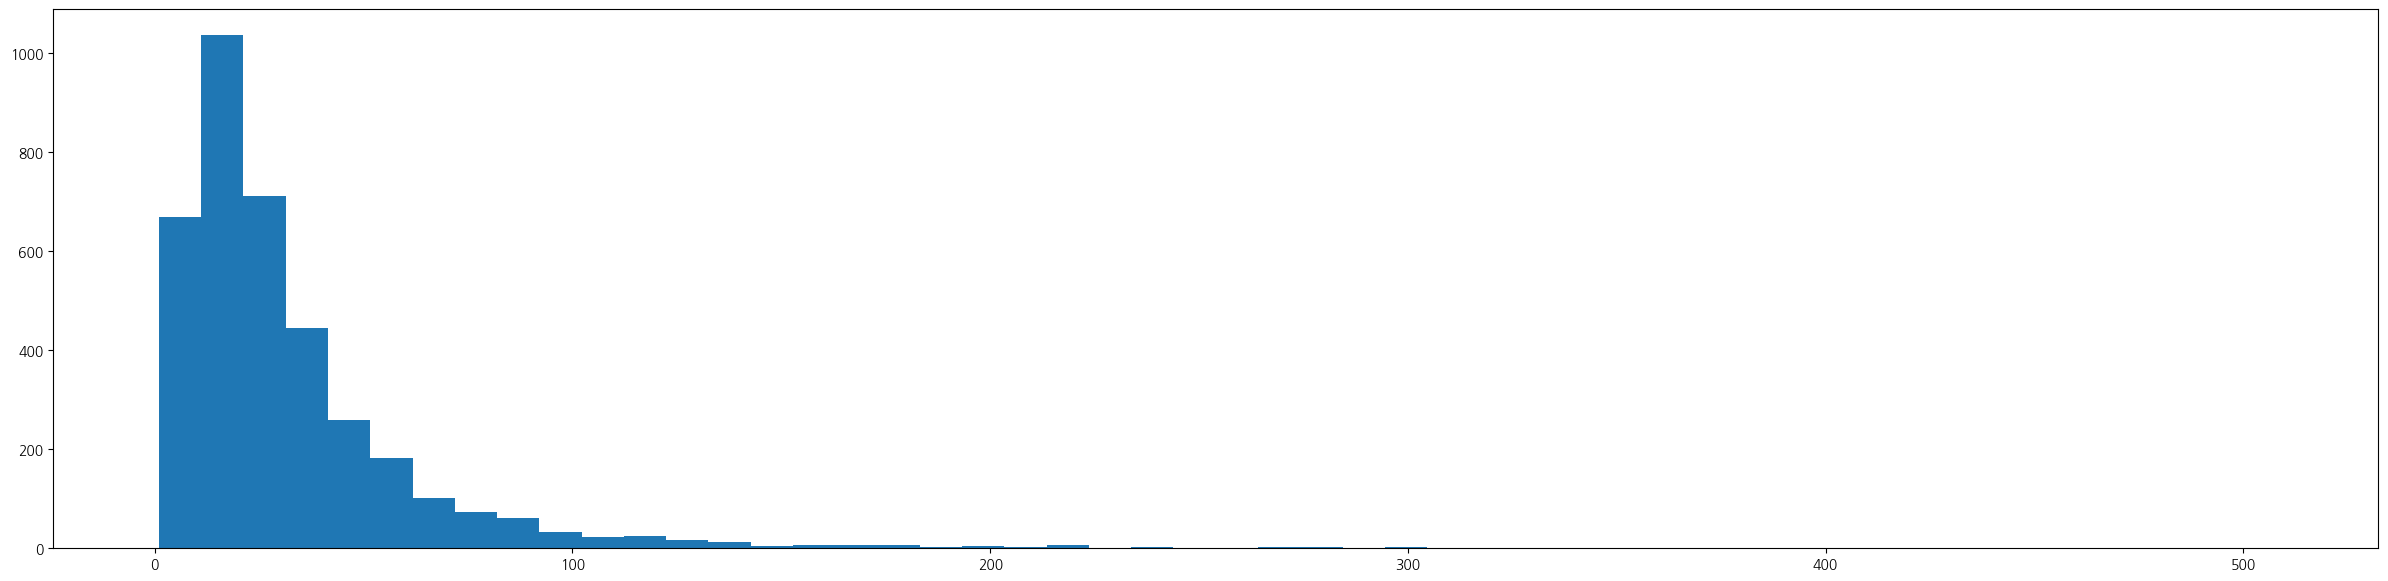

In [ ]:
plt.figure(figsize=(30, 7))
plt.hist(texts_len_by_words, bins=50)

### 3-2. 명사 추출하고 품사 태깅하기

* konlpy, MeCab을 활용하여 품사 태깅, 명사 추출하기.
* 2개 이상의 형태소 분석기를 Time analysis 해보기
* Number of Samples / Number of words per sample 구해보기

In [ ]:
# python package mecab
from mecab import MeCab
mecab = MeCab()

text_noun = []
text_pos= []

for i in texts:
  text_noun.append(mecab.nouns(i))
  text_pos.append(mecab.pos(i))
  #print(mecab.morphs(i))

In [ ]:
print(text_noun[:2])
print(text_pos[:2])

[['여기', '커널', '사이즈', '은', '단어', '최대', '길이', '가정', '선언', '것'], ['이미지', '개', '업로드', '자바', '스크립트', '동적', '폼', '개', '생성', '데', '클릭', '뭘', '수', '기본', '예제', '코드', '이유', '뭘까요']]
[[('self', 'SL'), ('.', 'SY'), ('convs', 'SL'), ('1', 'SN'), ('=', 'SY'), ('nn', 'SL'), ('.', 'SY'), ('ModuleList', 'SL'), ('(', 'SSO'), ('[', 'SSO'), ('nn', 'SL'), ('.', 'SY'), ('Conv', 'SL'), ('2', 'SN'), ('d', 'SL'), ('(', 'SSO'), ('1', 'SN'), (',', 'SC'), ('Co', 'SL'), (',', 'SC'), ('(', 'SSO'), ('K', 'SL'), (',', 'SC'), ('100', 'SN'), (')', 'SSC'), (')', 'SSC'), ('for', 'SL'), ('K', 'SL'), ('in', 'SL'), ('Ks', 'SL'), (']', 'SSC'), (')', 'SSC'), ('1', 'SN'), ('.', 'SF'), ('여기', 'NP'), ('서', 'JKB'), ('커널', 'NNG'), ('사이즈', 'NNG'), ('K', 'SL'), (',', 'SC'), ('100', 'SN'), ('은', 'NNG'), ('한', 'MM'), ('단어', 'NNG'), ('의', 'JKG'), ('최대', 'NNG'), ('길이', 'NNG'), ('가', 'JKS'), ('100', 'SN'), ('이', 'JKS'), ('넘', 'VV'), ('지', 'EC'), ('않', 'VX'), ('는다는', 'ETM'), ('가정', 'NNG'), ('으로', 'JKB'), ('그냥', 'MAG'), ('100', 'SN'), ('으로'

In [ ]:
from konlpy.tag import Okt
okt = Okt()
for i in texts:
  print(okt.nouns(i))
  print(okt.pos(i))
  print(okt.morphs(i))
  break

['여기', '커널', '사이즈', '은', '단어', '최대', '길이', '이', '가정', '그냥', '선언', '것']
[('self', 'Alpha'), ('.', 'Punctuation'), ('convs', 'Alpha'), ('1', 'Number'), ('=', 'Punctuation'), ('nn', 'Alpha'), ('.', 'Punctuation'), ('ModuleList', 'Alpha'), ('([', 'Punctuation'), ('nn', 'Alpha'), ('.', 'Punctuation'), ('Conv', 'Alpha'), ('2', 'Number'), ('d', 'Alpha'), ('(', 'Punctuation'), ('1', 'Number'), (',', 'Punctuation'), ('Co', 'Alpha'), (',', 'Punctuation'), ('(', 'Punctuation'), ('K', 'Alpha'), (',', 'Punctuation'), ('100', 'Number'), ('))', 'Punctuation'), ('for', 'Alpha'), ('K', 'Alpha'), ('in', 'Alpha'), ('Ks', 'Alpha'), ('])', 'Punctuation'), ('\n', 'Foreign'), ('1', 'Number'), ('.', 'Punctuation'), ('여기', 'Noun'), ('서', 'Josa'), ('커널', 'Noun'), ('사이즈', 'Noun'), ('K', 'Alpha'), (',', 'Punctuation'), ('100', 'Number'), ('은', 'Noun'), ('한', 'Verb'), ('단어', 'Noun'), ('의', 'Josa'), ('최대', 'Noun'), ('길이', 'Noun'), ('가', 'Josa'), ('100', 'Number'), ('이', 'Noun'), ('넘지', 'Verb'), ('않는다는', 'Verb'), ('

In [ ]:
#Time analysis
from time import time
from konlpy import tag

def measure_time(taggers, mult=6):
    diffs = []
    data=[]
    for tagger in taggers:
        times = [time()]
        for i in texts:
          r = getattr(tag, tagger)().pos(i)
          data.append(r)
        times.append(time())
        diffs.append(times[-1] - times[-2])
    return diffs, data

taggers = [t for t in dir(tag) if t[0].isupper()]  #형태소 분석기 종류 ['Hannanum', 'Kkma', 'Komoran', 'Mecab', 'Okt', 'Twitter']
taggers = ['Twitter', 'Okt']
time, data = measure_time(taggers)

print(time)

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[23.618935346603394, 22.574968099594116]


In [ ]:
from konlpy import tag
taggers = [t for t in dir(tag) if t[0].isupper()]
taggers

['Hannanum', 'Kkma', 'Komoran', 'Mecab', 'Okt', 'Twitter']

In [ ]:
#Number of Samples / Number of words per sample(샘플당 단어 수 )
sample_su = len(texts)
num_words_per_sample = [len(i.split()) for i in texts]

sample_su /  np.median(num_words_per_sample)

161.1304347826087

### 3-3. nltk로 텍스트 분석하기
* 3-2.의 명사 추출, 품사 태깅한 데이터를 nltk Text로 변경하기
* 각각 token 갯수 / 전체 token 비율(Type-Token Ratio) 알아보기
* 각각 Frequency 확인 및 분포 시각화
* 명사 추출한 데이터에서 코드, 웹, 이론, 원격, 시스템 등 관심있는 각 단어에 분석해보기
* 각각 collocation 확인
* 최소 길이 문의 내용에 대해 grammar pasing 해보기(아래 코드 활용)


```python
grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"
```

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# nltk Text로 변경하기
nltks = []
for i in range(len(train_df)):
    text = nltk.word_tokenize(train_df.loc[i, 'text'])
    nltks.append(nltk.pos_tag(text))
# 각 token별 빈도 확인 및 분포 시각화
type_token = []
for i in range(len(train_df)):
    count = {}
    for j in range(len(nltks[i])):
        if nltks[i][j] in count:
            count[nltks[i][j]] += 1
        else:
            count[nltks[i][j]] = 1
    type_token.append(count)
# 각각 token 갯수 / 전체 token 비율(Type-Token Ratio) 알아보기
type_token_ratio = []
for i in range(len(train_df)):
    ratio = {}
    for j in range(len(nltks[i])):
        if nltks[i][j] in ratio:
            ratio[nltks[i][j]] += (1 / len(nltks[i]))
        else:
            ratio[nltks[i][j]] = (1 / len(nltks[i]))
    type_token_ratio.append(ratio)

(array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],


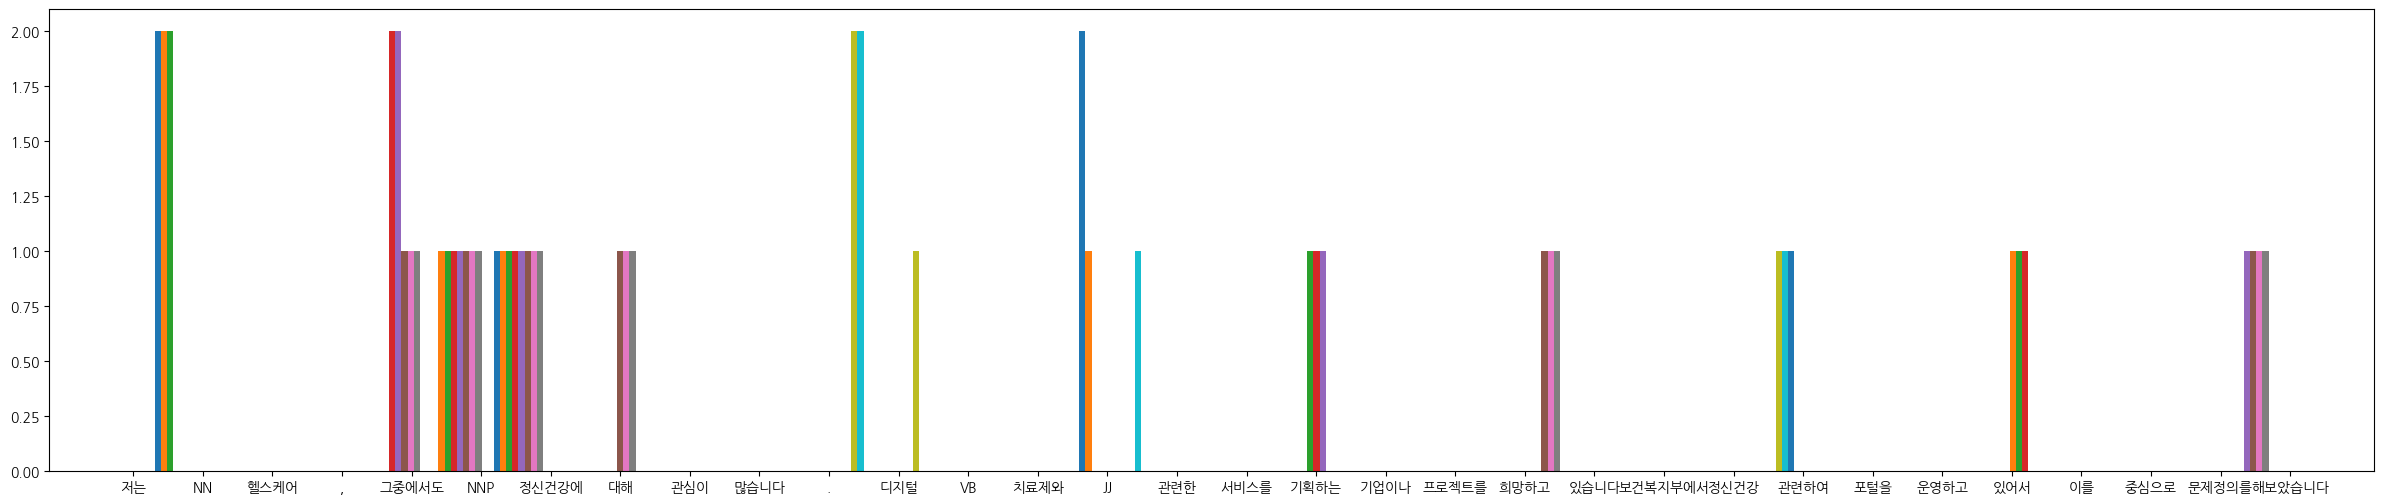

In [ ]:
type_token[5]
type_token_ratio[5]
plt.figure(figsize=(30, 6))
plt.hist(type_token[5])

In [ ]:
text_noun

[['여기', '커널', '사이즈', '은', '단어', '최대', '길이', '가정', '선언', '것'],
 ['이미지',
  '개',
  '업로드',
  '자바',
  '스크립트',
  '동적',
  '폼',
  '개',
  '생성',
  '데',
  '클릭',
  '뭘',
  '수',
  '기본',
  '예제',
  '코드',
  '이유',
  '뭘까요'],
 ['사용',
  '때',
  '질문',
  '포함',
  '작동',
  '것',
  '질문',
  '제공',
  '파일',
  '폴더',
  '포함',
  '폴더',
  '안',
  '정상',
  '작동'],
 ['오류', '해결'],
 ['안', '폴더', '안', '이미지', '저장', '걸로', '이해', '실행', '폴더', '이미지', '저장', '질문'],
 ['저',
  '헬스',
  '중',
  '정신',
  '건강',
  '관심',
  '디지털',
  '치료제',
  '관련',
  '서비스',
  '기획',
  '기업',
  '프로젝트',
  '희망',
  '보건복지부',
  '정신',
  '건강',
  '관련',
  '포털',
  '운영',
  '이',
  '중심',
  '문제',
  '정의'],
 ['파일',
  '페이지',
  '제',
  '안사',
  '인프라',
  '구성',
  '웹',
  '서버',
  '솔루션',
  '대',
  '통합',
  '제시',
  '때',
  '배치도',
  '작성',
  '이중화',
  '표현',
  '작성',
  '대로',
  '통합',
  '배치',
  '걸까요'],
 ['범주',
  '데이터',
  '숫자',
  '데이터',
  '설명',
  '내용',
  '적응',
  '아래',
  '첨부',
  '파일',
  '실습',
  '데이터',
  '서울시',
  '릉',
  '시간',
  '비',
  '데이터',
  '저',
  '데이터',
  '범주',
  '데이터',
  '생각',
  '제',
  '의도',
  '값',
  '시간',

In [ ]:
def count_token(arr_nouns):
    total_token = {}
    for nouns in arr_nouns:
        if nouns in total_token:
            total_token[nouns] += 1
        else:
            total_token[nouns] = 1

    return total_token

In [ ]:
total_nouns = []
for li in text_noun:
    for i in li:
        total_nouns.append(i)

total_nouns

['여기',
 '커널',
 '사이즈',
 '은',
 '단어',
 '최대',
 '길이',
 '가정',
 '선언',
 '것',
 '이미지',
 '개',
 '업로드',
 '자바',
 '스크립트',
 '동적',
 '폼',
 '개',
 '생성',
 '데',
 '클릭',
 '뭘',
 '수',
 '기본',
 '예제',
 '코드',
 '이유',
 '뭘까요',
 '사용',
 '때',
 '질문',
 '포함',
 '작동',
 '것',
 '질문',
 '제공',
 '파일',
 '폴더',
 '포함',
 '폴더',
 '안',
 '정상',
 '작동',
 '오류',
 '해결',
 '안',
 '폴더',
 '안',
 '이미지',
 '저장',
 '걸로',
 '이해',
 '실행',
 '폴더',
 '이미지',
 '저장',
 '질문',
 '저',
 '헬스',
 '중',
 '정신',
 '건강',
 '관심',
 '디지털',
 '치료제',
 '관련',
 '서비스',
 '기획',
 '기업',
 '프로젝트',
 '희망',
 '보건복지부',
 '정신',
 '건강',
 '관련',
 '포털',
 '운영',
 '이',
 '중심',
 '문제',
 '정의',
 '파일',
 '페이지',
 '제',
 '안사',
 '인프라',
 '구성',
 '웹',
 '서버',
 '솔루션',
 '대',
 '통합',
 '제시',
 '때',
 '배치도',
 '작성',
 '이중화',
 '표현',
 '작성',
 '대로',
 '통합',
 '배치',
 '걸까요',
 '범주',
 '데이터',
 '숫자',
 '데이터',
 '설명',
 '내용',
 '적응',
 '아래',
 '첨부',
 '파일',
 '실습',
 '데이터',
 '서울시',
 '릉',
 '시간',
 '비',
 '데이터',
 '저',
 '데이터',
 '범주',
 '데이터',
 '생각',
 '제',
 '의도',
 '값',
 '시간',
 '대별',
 '비',
 '과',
 '방법',
 '사용',
 '출력',
 '의도',
 '대로',
 '질문',
 '변량',
 '분석',
 '변량',
 '분석',
 '아래

In [ ]:
total_word = count_token(total_nouns)
words_count = dict(sorted(total_word.items(), key = lambda x:x[1], reverse = True))
words_count

{'것': 1093,
 '수': 986,
 '값': 801,
 '데이터': 783,
 '문제': 725,
 '때': 714,
 '코드': 712,
 '실습': 609,
 '번': 596,
 '파일': 581,
 '감사': 528,
 '안녕': 528,
 '오류': 521,
 '부분': 510,
 '질문': 503,
 '문': 476,
 '사용': 468,
 '경우': 467,
 '확인': 449,
 '진행': 432,
 '입력': 418,
 '건가요': 407,
 '제': 388,
 '중': 366,
 '실행': 365,
 '개': 357,
 '모델': 350,
 '이해': 347,
 '제출': 345,
 '변수': 335,
 '출력': 334,
 '결과': 314,
 '방법': 307,
 '에러': 289,
 '시간': 284,
 '후': 276,
 '게': 265,
 '해결': 259,
 '작성': 259,
 '거': 253,
 '해당': 247,
 '시': 234,
 '추가': 234,
 '발생': 222,
 '강사': 219,
 '위': 216,
 '부탁': 210,
 '일': 205,
 '첨부': 204,
 '함수': 204,
 '걸까요': 202,
 '이': 198,
 '이유': 197,
 '내용': 195,
 '가능': 194,
 '다음': 192,
 '학습': 187,
 '설정': 187,
 '생각': 186,
 '건지': 186,
 '관련': 185,
 '설명': 180,
 '과정': 173,
 '아래': 172,
 '의미': 172,
 '무엇': 167,
 '강의': 164,
 '열': 163,
 '답변': 157,
 '사진': 157,
 '차이': 154,
 '분석': 152,
 '저장': 151,
 '예측': 148,
 '생성': 146,
 '데': 145,
 '하나': 145,
 '이용': 143,
 '이미지': 141,
 '테스트': 141,
 '코딩': 141,
 '점': 135,
 '분': 132,
 '어디': 130,
 '이상':

In [ ]:
key = list(words_count.keys())
value = list(words_count.values())

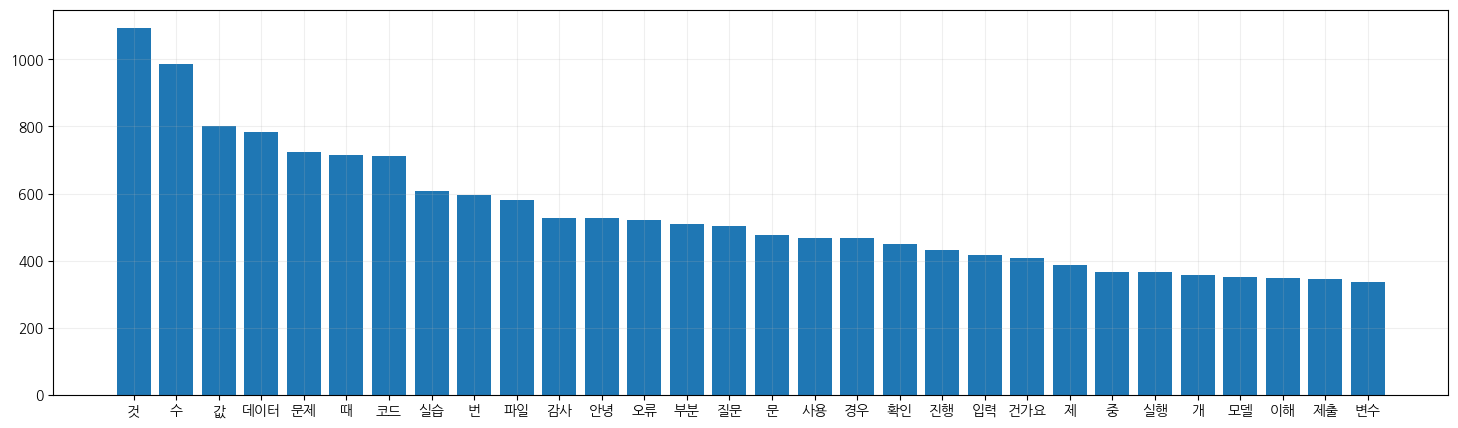

In [ ]:
plt.figure(figsize = (18, 5))
df_plot = pd.DataFrame()
df_plot['Word'] = key
df_plot['Count'] = value

plt.bar(df_plot['Word'].iloc[0:30], df_plot['Count'].iloc[0:30])
plt.grid(alpha = 0.2)
plt.show()

### 3-4. Wordcloud 만들기
* 명사 추출/형태소 분석 결과를 이용하여 WordCloud 객체를 생성
* 최대 글꼴 크기(max_font_size), 최대 단어 수(max_words), 배경 색상(background_color)
* 상대 크기비율(relative_scaling), 그림 크기(width, height), 폰트 경로(font_path=FONT_PATH) 등 설정
* .generate 메서드를 연결하여 WordCloud에 사용될 텍스트 데이터 생성
* plt.imshow(  ) 를 통해 화면에 보여집니다.

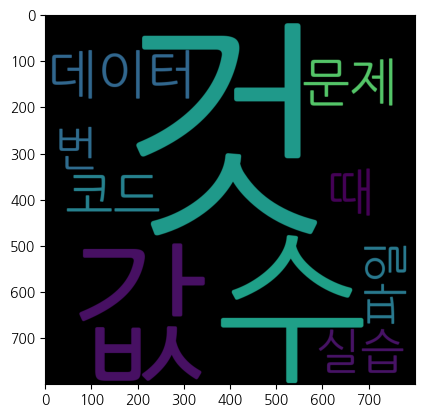

In [ ]:
wc = WordCloud(width=400, height=400, scale=2.0, max_font_size=250, max_words = 10, font_path=FONT_PATH)
gen = wc.generate_from_frequencies(words_count)
plt.figure()
plt.imshow(gen)

## 4. 문의 유형에 따른 분석
### 4-1. *3. 데이터 탐색*에서 실행한 알고리즘을 문의 유형에 따라 실행할 수 있는 함수를 개발합니다.
* 아래 text_analysis 함수를 개발합니다.

In [ ]:
def text_analysis(df, label=None):
    """
    label에 따라서 분석, label이 None인 경우 전체 분석
    데이터 확인, 데이터 길이 시각화
    명사 추출하여 분석, 워드 클라우드 시각화

    Parameters
    ----------
    df : pandas DataFrame object.
    label : Label for analysis, default=None.
    - If label is None, Entire data are analyzed.

    Returns
    -------
    result : None

    """
    # label에 따라 df 설정
    if label == None:
        pass
    else:
        df = df.loc[df['label'] == label]

    # 데이터 확인
    print('--------------------데이터 확인-------------------------------')
    print("데이터 형태:", df.info())
    print('--------------------길이-------------------------------')
    # 데이터의 최대 길이와 최소 길이를 구한다.
    text = list(df['text'])
    text_len = [ len(i) for i in text]

    min_num = min(text_len)
    min_index = text_len.index(min_num)
    max_num = max(text_len)
    max_index = text_len.index(max_num)

    print('최소:',min_num , ' 최대: ', max_num )
    print('타입:', type(min_index))
    print('최대 길이 문서 인덱스:', max_index)
    print('최소 길이 문서 인덱스:', min_index)
    print('최대 길이 문서 내용:', text[max_index])
    print('최소 길이 문서 내용:', text[min_index])

    plt.figure(figsize=(12,5))
    plt.hist(text_len, bins=100, color='b')
    plt.xlabel('문서길이')
    plt.show()
    print('-------------------- 명사 추출 -------------------------------')

    # 명사 추출
    mecab = MeCab()
    mecab_Nouns = []
    for text in df['text']:
        mecab_Nouns.append(mecab.nouns(text))

    total_nouns = []
    for li in mecab_Nouns:
        for i in li:
            total_nouns.append(i)

    # 출현하는 단어의 개수 세기
    total_token = {}
    for nouns in total_nouns:
        if nouns in total_token:
            total_token[nouns] += 1
        else:
            total_token[nouns] = 1

    d = dict(sorted(total_token.items(), key = lambda x:x[1], reverse = True))
    print('--------------------단어별 빈도수-------------------------------')
    # 단어별 빈도수
    print(d)
    key = list(d.keys())
    value = list(d.values())
    plt.figure(figsize = (15, 7))
    df_plot = pd.DataFrame()
    df_plot['Word'] = key
    df_plot['Count'] = value

    plt.bar(df_plot['Word'].iloc[0:30], df_plot['Count'].iloc[0:30])
    plt.grid(alpha = 0.2)
    plt.show()

    #워드 클라우드 실행
    print('--------------------워드 클라우드--------------------------------')
    wc = WordCloud(width=400, height=400, scale=2.0, max_font_size=250, max_words = 10, font_path=FONT_PATH)
    gen = wc.generate_from_frequencies(d)
    plt.figure()
    plt.imshow(gen)
    print('#######################################################################')

### 4-2. 각각의 문의 유형에 대해 실행합니다.

--------------------데이터 확인-------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 0 to 3701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1097 non-null   object
 1   label   1097 non-null   object
dtypes: object(2)
memory usage: 25.7+ KB
데이터 형태: None
--------------------길이-------------------------------
최소: 13  최대:  6012
타입: <class 'int'>
최대 길이 문서 인덱스: 760
최소 길이 문서 인덱스: 756
최대 길이 문서 내용: sns.kdeplot(x = td[var])
plt.show()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
 in 
----&gt; 1 sns.kdeplot(x = td[var])
      2 plt.show()

~\anaconda3\lib\site-packages\seaborn\_decorators.py in inner_f(*args, **kwargs)
     44             )
     45         kwargs.update({k: arg for k, arg in zip(sig.parameters, args)})
---&gt; 46         return f(**kwargs)
     47     return inner_f
 

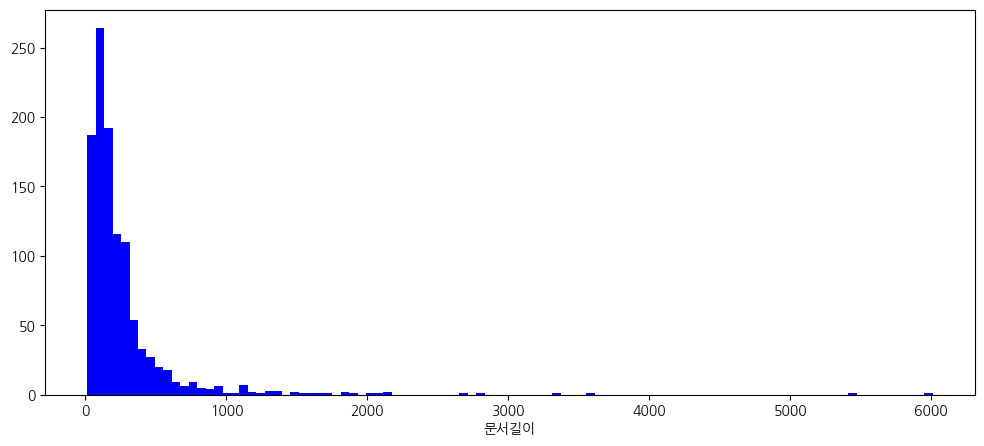

-------------------- 명사 추출 -------------------------------
--------------------단어별 빈도수-------------------------------
{'데이터': 405, '코드': 336, '값': 303, '것': 280, '오류': 253, '수': 251, '때': 195, '문제': 186, '부분': 173, '에러': 170, '모델': 169, '사용': 168, '파일': 166, '번': 161, '확인': 147, '실습': 145, '실행': 144, '진행': 143, '건가요': 131, '감사': 131, '질문': 125, '결과': 122, '개': 120, '변수': 115, '방법': 112, '안녕': 112, '열': 111, '위': 109, '시간': 107, '발생': 105, '프레임': 98, '중': 96, '후': 92, '경우': 90, '결': 89, '학습': 89, '문': 89, '측': 88, '작성': 87, '해결': 86, '제거': 86, '아래': 83, '이해': 81, '해당': 80, '게': 77, '과정': 72, '제': 72, '이유': 71, '시': 71, '걸까요': 71, '저장': 70, '이미지': 69, '무엇': 69, '전처리': 68, '분석': 67, '추가': 67, '이용': 64, '강사': 61, '입력': 61, '출력': 60, '거': 60, '설정': 59, '변경': 58, '함수': 58, '첨부': 58, '이': 58, '선언': 57, '사진': 56, '평균': 55, '의미': 55, '지정': 54, '여기': 51, '건지': 51, '그래프': 51, '자치구': 51, '이상': 50, '분': 49, '다음': 48, '행': 46, '기준': 46, '식': 45, '변환': 45, '예측': 44, '데': 43, '생성': 43, '수정': 42, '이동':

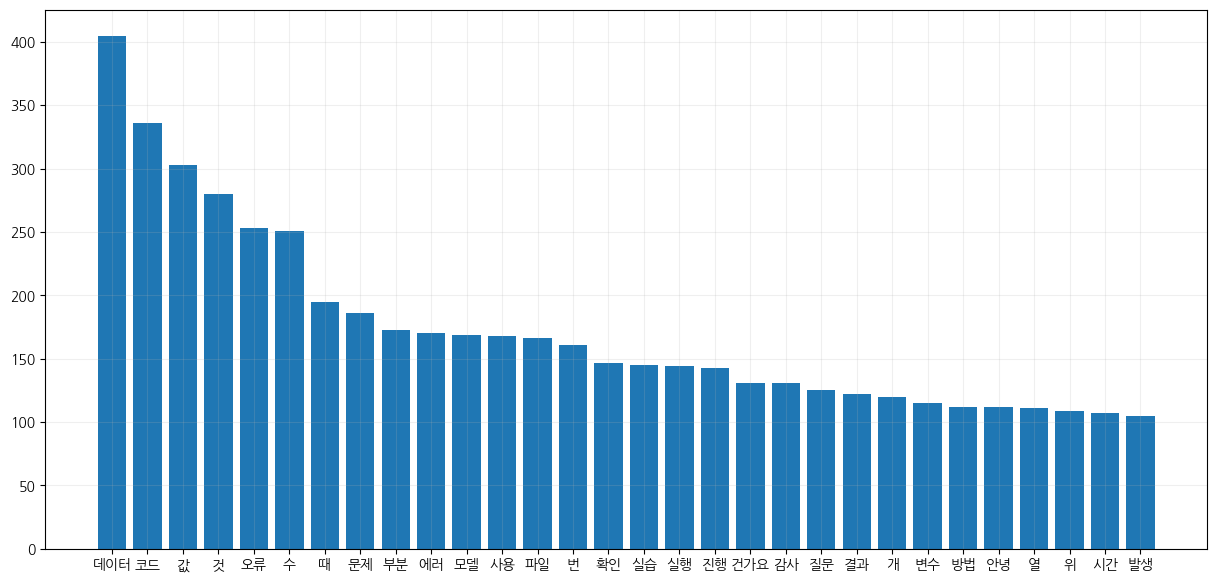

--------------------워드 클라우드--------------------------------
#######################################################################


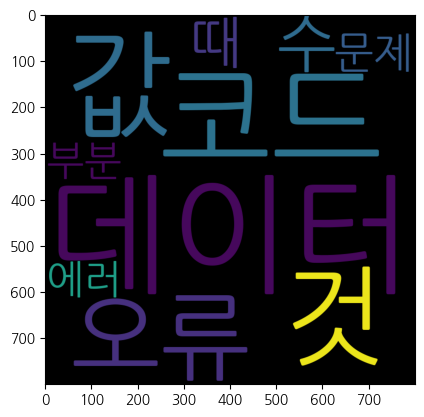

In [ ]:
text_analysis(train_df, '코드2')

--------------------데이터 확인-------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 12 to 3702
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    561 non-null    object
 1   label   561 non-null    object
dtypes: object(2)
memory usage: 13.1+ KB
데이터 형태: None
--------------------길이-------------------------------
최소: 10  최대:  650
타입: <class 'int'>
최대 길이 문서 인덱스: 358
최소 길이 문서 인덱스: 434
최대 길이 문서 내용: 안녕하십니까 다름아니라 8월 11일에 치룬 셀프테스트 결과를 확인하고 문의드릴점이 있어 글을 작성하게되었습니다 다름아니라 A-2번 문제는 실습A-2에서 실수값을 갖는 열의 개수를 구하는 문제입니다 저는 해당 문제를 풀기위해 info()함수를 제대로 이용하여 실수형 열의 개수를 구했습니다 저는 앞선 문제에서 mall 데이터에 열을 추가하는 문제를 먼저 푸는 바람에 A-2번 문제를 풀게되었을때 실수형태의 열 개수가 추가되어 기존의 실수형 형태의 열 개수가 2개에서 3개로 바뀌어 제 답안에는 실수형 열 개수가 3개라는 결과를 얻게되었습니다ㅠㅠ.. 이 경우에는 부분점수를 받거나 점수 변동이 가능할까요? 제 실습 파일을 보면 알 수 있듯이 사용해야하는 함수도 제대로 썼지만 앞서 열 추가 문제를 먼저 푸는 바람에 A-2번 문제를 풀때 열추가가된 것 같습니다.. 

추가로 95점 이상 남성을 구하는 문제에 있어 제가 등호표시를 &gt;로만 하여 아쉽게 오답으로 처리되었는데요.. 이 경우도 부분점

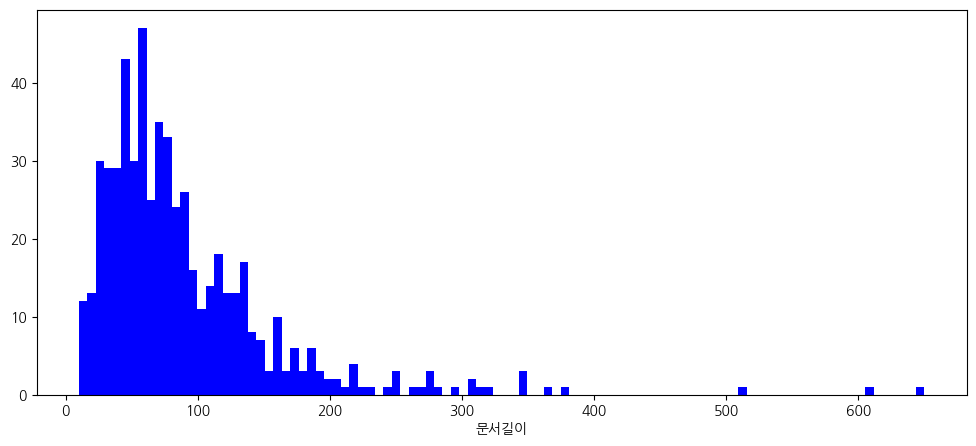

-------------------- 명사 추출 -------------------------------
--------------------단어별 빈도수-------------------------------
{'제출': 316, '파일': 224, '수': 132, '확인': 125, '것': 124, '안녕': 113, '문제': 112, '문': 103, '강의': 103, '실습': 97, '과제': 92, '번': 80, '감사': 78, '시간': 76, '프로젝트': 75, '제': 68, '진행': 67, '첨부': 63, '시험': 63, '일': 63, '가능': 63, '접속': 58, '테스트': 57, '중': 57, '때': 56, '차': 56, '시': 52, '분': 52, '셀프': 51, '미니': 49, '코드': 48, '부탁': 48, '조': 47, '건가요': 46, '조별': 46, '내용': 45, '오류': 44, '데이터': 43, '방법': 42, '영상': 41, '질문': 41, '사용': 41, '거': 40, '부분': 40, '경우': 38, '개인': 34, '장': 34, '자료': 34, '수업': 34, '발표': 33, '개': 33, '업로드': 32, '링크': 32, '코딩': 31, '후': 31, '강사': 31, '문의': 29, '관련': 29, '다운로드': 29, '다음': 28, '개별': 28, '노트북': 28, '결과': 28, '점수': 28, '다운': 28, '답변': 27, '전': 25, '게': 25, '해결': 25, '데': 24, '화면': 24, '점': 24, '이번': 24, '창': 23, '저장': 23, '학습': 23, '상태': 23, '마스터스': 22, '페이지': 22, '번호': 21, '답안': 21, '등': 20, '글': 20, '작성': 20, '실행': 20, '어디': 20, '복습': 20, '해당': 20, '월'

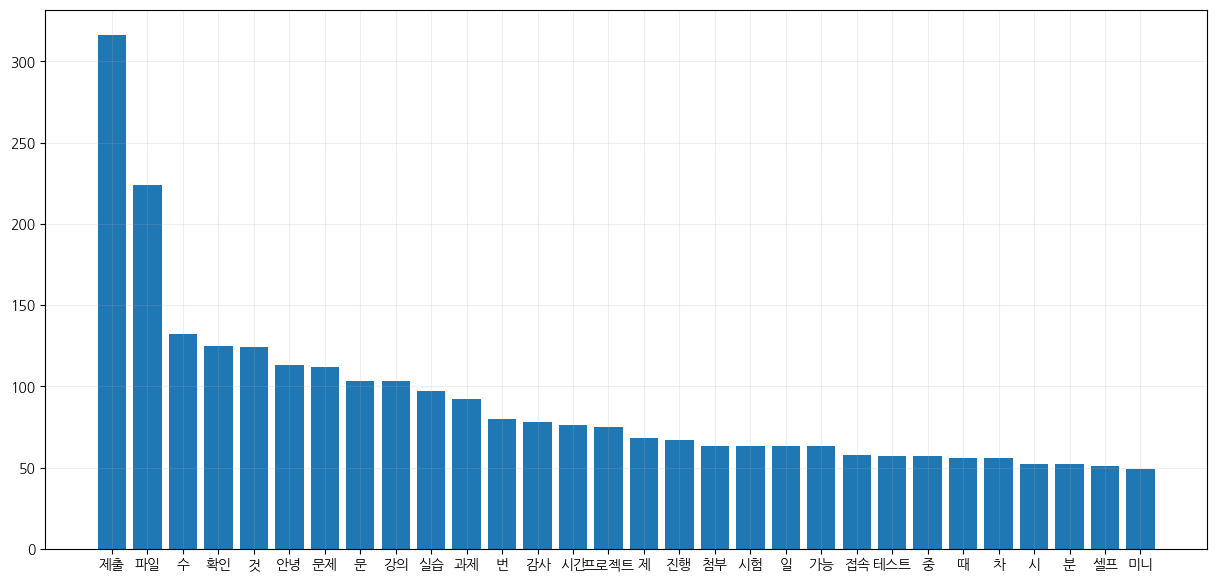

--------------------워드 클라우드--------------------------------
#######################################################################
--------------------데이터 확인-------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 37 to 3704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
 1   label   100 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB
데이터 형태: None
--------------------길이-------------------------------
최소: 9  최대:  683
타입: <class 'int'>
최대 길이 문서 인덱스: 5
최소 길이 문서 인덱스: 17
최대 길이 문서 내용: 튜터님,

말씀해주신 urls.py 부분 해결하였습니다. 감사합니다.

하지만 아래 코드 실행시 또다른 에러가 발생합니다.
- C:\dev\mini_pro7&gt;python manage.py migrate
- C:\dev\mini_pro7&gt;python manage.py runserver

에러내용은 아래와 같습니다.
- OSError: [WinError 123] 파일 이름, 디렉터리 이름 또는 볼륨 레이블 구문이 잘못 
되었습니다: ''
- ModuleNotFoundError: No module named 'reference.urls'

문제 해결을 위해 https://bladewalker.tistory.com/713와 https://stackoverf

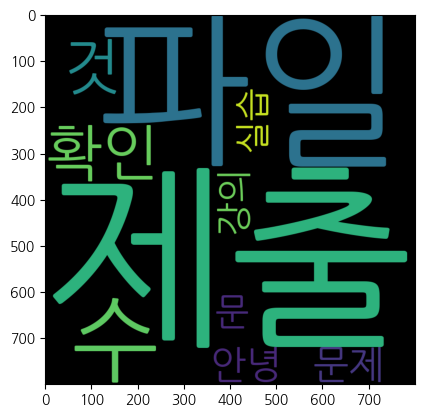

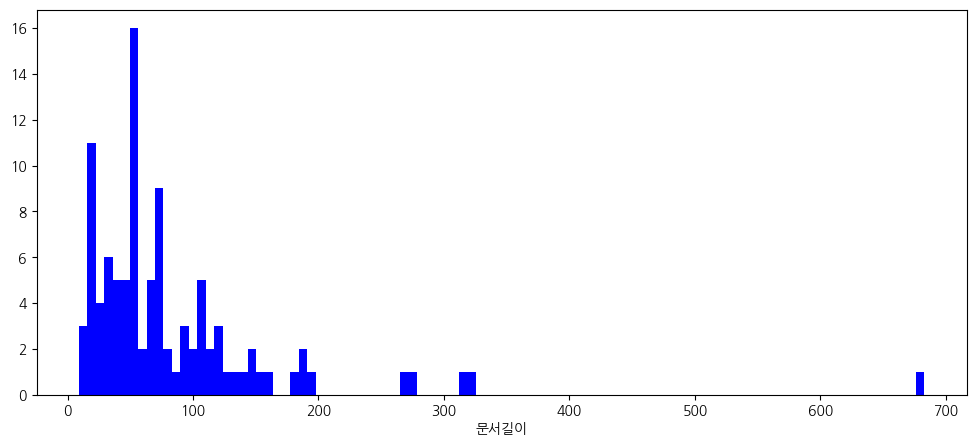

-------------------- 명사 추출 -------------------------------
--------------------단어별 빈도수-------------------------------
{'원격': 98, '지원': 51, '부탁': 26, '요청': 26, '수': 23, '오류': 19, '실행': 17, '해결': 15, '감사': 15, '안녕': 15, '파일': 13, '문제': 13, '코드': 12, '것': 11, '확인': 10, '가능': 9, '입력': 9, '질문': 9, '실습': 9, '진행': 9, '발생': 8, '부분': 8, '거': 8, '문': 8, '번': 8, '모델': 8, '링크': 7, '접속': 7, '중': 7, '삭제': 6, '에러': 6, '관련': 6, '강사': 6, '도움': 6, '제': 6, '말씀': 5, '제어': 5, '시': 5, '후': 5, '창': 5, '다음': 5, '사용': 5, '랩': 5, '설정': 5, '해당': 5, '저장': 5, '가중치': 5, '가상': 4, '종료': 4, '때': 4, '설치': 4, '경로': 4, '그룹': 4, '지정': 4, '대로': 3, '안내': 3, '프로그램': 3, '하단': 3, '튜': 3, '터': 3, '쪽': 3, '스턴스': 3, '주피터': 3, '장': 3, '로딩': 3, '팀': 3, '이미지': 3, '서브': 3, '넷': 3, '인': 3, '어디': 3, '노트북': 3, '걸까요': 3, '윈도우': 3, '로그인': 3, '자체': 3, '화면': 3, '카메라': 3, '이해': 3, '보안': 3, '이번': 2, '명령어': 2, '수행': 2, '조정': 2, '시간': 2, '일': 2, '번호': 2, '준비': 2, '네트워크': 2, '내용': 2, '아래': 2, '이름': 2, '지속': 2, '팀원': 2, '재설': 2, '환경': 2, '추가': 2,

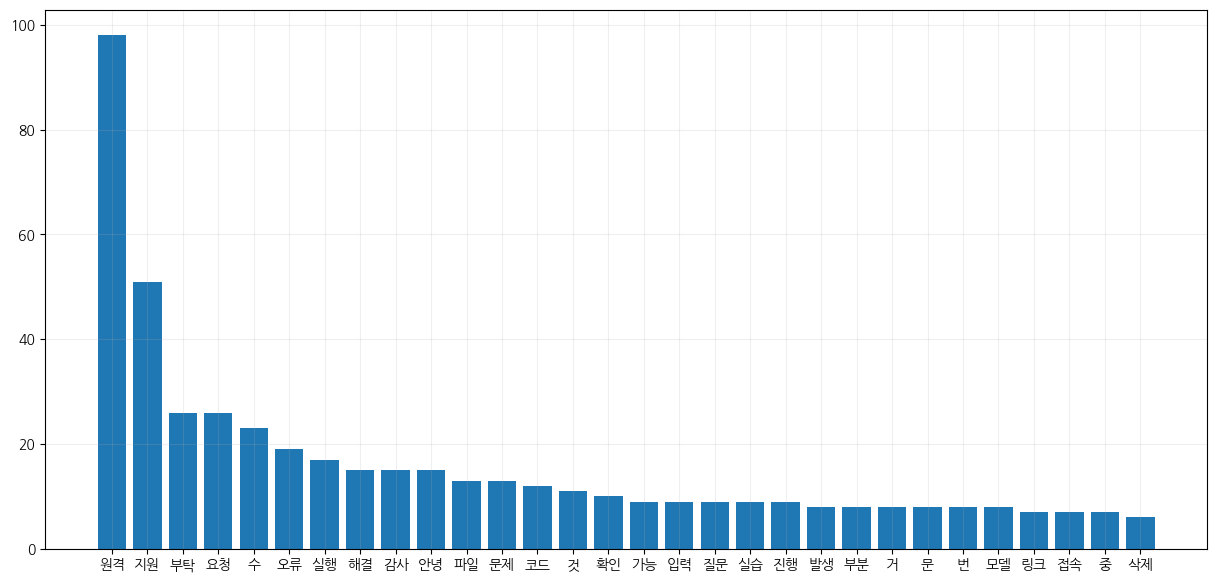

--------------------워드 클라우드--------------------------------
#######################################################################
--------------------데이터 확인-------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 732 entries, 1 to 3700
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    732 non-null    object
 1   label   732 non-null    object
dtypes: object(2)
memory usage: 17.2+ KB
데이터 형태: None
--------------------길이-------------------------------
최소: 13  최대:  5690
타입: <class 'int'>
최대 길이 문서 인덱스: 236
최소 길이 문서 인덱스: 107
최대 길이 문서 내용: $ python manage.py createsuperuser

You have 18 unapplied migration(s). Your project may not work properly until you apply the migrations for app(s): admin, auth, contenttypes, sessions.
Run 'python manage.py migrate' to apply them.
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\django\db\backends\ut

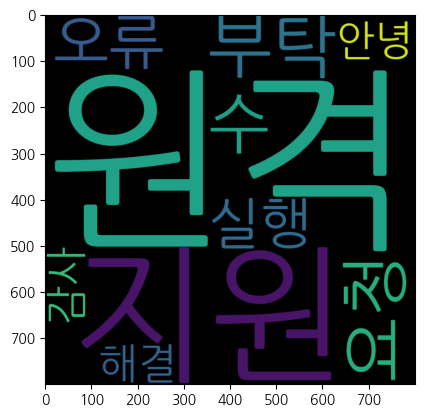

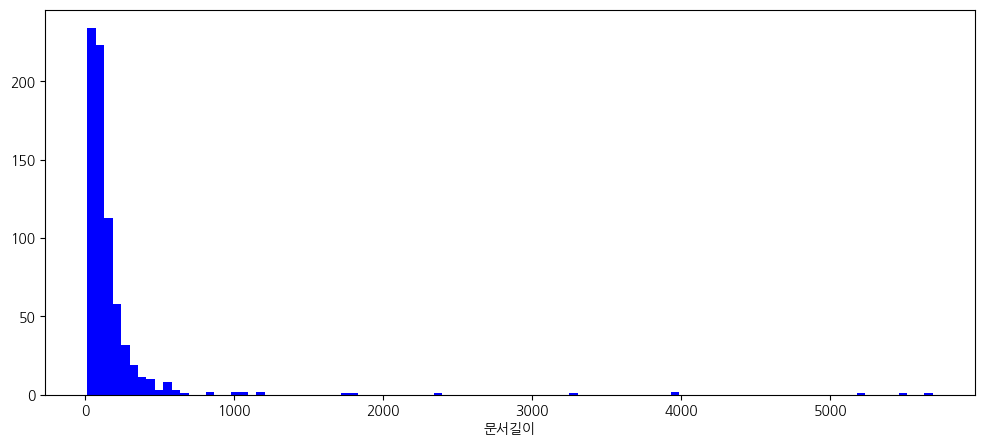

-------------------- 명사 추출 -------------------------------
--------------------단어별 빈도수-------------------------------
{'실습': 159, '오류': 146, '수': 142, '것': 137, '파일': 123, '실행': 123, '진행': 109, '부분': 108, '때': 99, '안녕': 99, '번': 98, '입력': 94, '스턴스': 90, '코드': 89, '감사': 86, '해결': 85, '후': 83, '확인': 76, '연결': 76, '문': 76, '생성': 75, '문제': 73, '설정': 73, '에러': 73, '건가요': 70, '중': 69, '인': 65, '발생': 65, '사용': 64, '질문': 59, '페이지': 57, '걸까요': 56, '창': 56, '모델': 53, '개': 51, '서버': 51, '강사': 49, '접속': 49, '거': 48, '제': 47, '명령어': 47, '방법': 47, '출력': 45, '데이터': 44, '시': 44, '사진': 43, '함수': 42, '추가': 42, '이해': 42, '해당': 41, '넷': 41, '게': 41, '서브': 40, '다음': 38, '값': 38, '클라우드': 37, '어디': 36, '설치': 36, '이미지': 35, '변경': 35, '과정': 35, '퍼블릭': 34, '수정': 34, '네트워크': 34, '결과': 33, '주소': 33, '웹': 32, '상태': 32, '화면': 31, '작성': 30, '그룹': 30, '변수': 30, '종료': 29, '건지': 29, '위': 29, '선택': 28, '경우': 28, '데': 27, '테이블': 27, '이름': 26, '아래': 26, '환경': 26, '이': 26, '삭제': 25, '시작': 25, '이후': 24, '설명': 24, '튜': 24, '

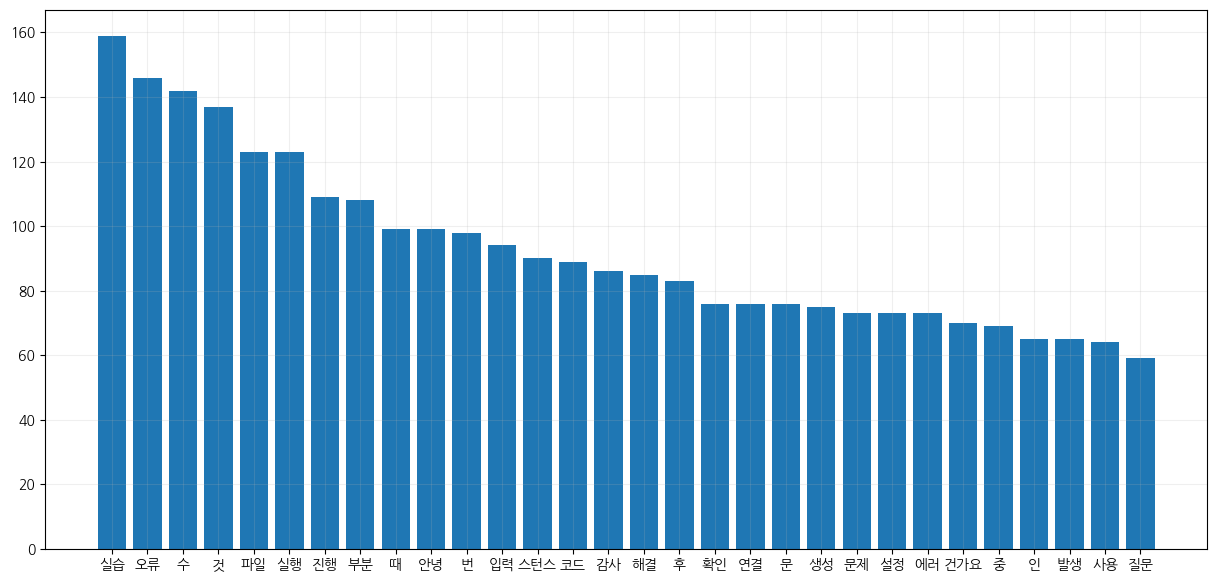

--------------------워드 클라우드--------------------------------
#######################################################################
--------------------데이터 확인-------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 5 to 3705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    728 non-null    object
 1   label   728 non-null    object
dtypes: object(2)
memory usage: 17.1+ KB
데이터 형태: None
--------------------길이-------------------------------
최소: 13  최대:  915
타입: <class 'int'>
최대 길이 문서 인덱스: 726
최소 길이 문서 인덱스: 12
최대 길이 문서 내용: 수업에서 cacoo랑 packet tracer를 배우는 이유가

1. IT 인프라 구조에 대해서 이해해보는 시간
- 비록 직접 인프라를 구축 및 설계는 하지 않을지라도 어떻게 구성되어 있고 어떻게 돌아가는지는 알아보자.
적절한 비유일지는 모르겠으나, 운전을 하는 게 목표라고 할 때, 
우리가 자동차를 직접 설계하고 만들지는 않아도 자동차가 연료를 연소시키면서 엔진에 동력을 전달해서 그 힘으로 움직인다. 라는 식으로 원리와 과정을 아는 것과 같은 맥락...이려나요?

2. (DX과정이므로 DX 컨설턴트 및 관련 직무를 위한 교육이라고 가정할 때) DX 관련 업무에서 실제로 IT 인프라를 구축해야하는 경우가 있으며, 이 때 실제 장비를 가지고 하나씩 연결해보

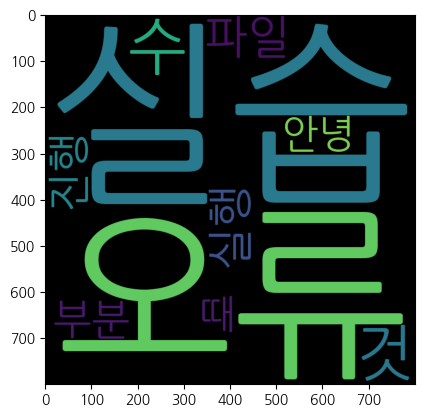

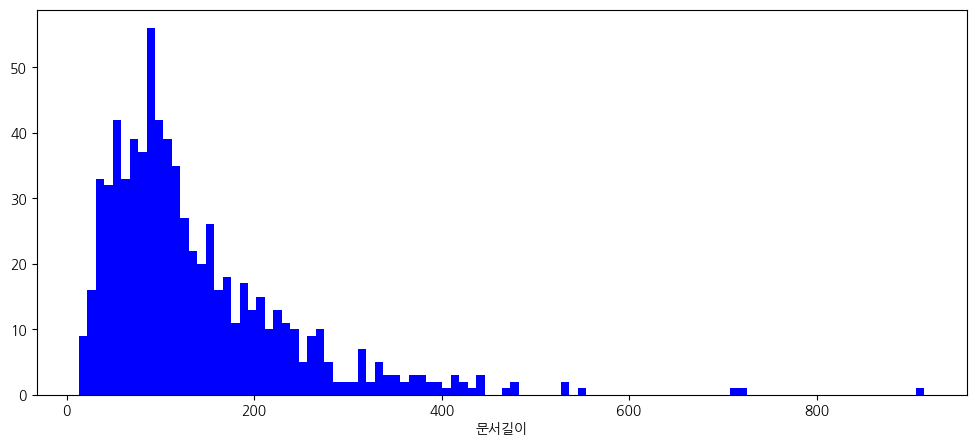

-------------------- 명사 추출 -------------------------------
--------------------단어별 빈도수-------------------------------
{'것': 375, '데이터': 276, '때': 209, '수': 199, '값': 198, '실습': 172, '경우': 162, '변수': 158, '이해': 151, '질문': 146, '사용': 119, '감사': 119, '건가요': 118, '모델': 107, '게': 99, '진행': 94, '안녕': 92, '부분': 89, '피드백': 88, '예측': 85, '고객': 85, '생각': 80, '제': 80, '차이': 79, '의미': 78, '중': 76, '문제': 75, '개': 73, '상관': 71, '번': 70, '설명': 69, '내용': 68, '분석': 68, '학습': 67, '시간': 66, '부탁': 66, '작성': 66, '관련': 65, '추가': 64, '거': 64, '문': 62, '이': 60, '일': 58, '강사': 57, '이유': 56, '러닝': 56, '해당': 55, '관계': 53, '서비스': 52, '기준': 52, '결과': 51, '요청': 50, '확인': 50, '계수': 49, '건지': 48, '방법': 46, '과정': 46, '가중치': 44, '파일': 42, '때문': 41, '범주': 40, '점': 40, '무엇': 40, '답변': 40, '걸까요': 39, '필요': 38, '설정': 38, '시': 38, '후': 37, '가능': 36, '평균': 36, '차': 35, '수업': 35, '이용': 35, '분류': 34, '하나': 34, '사': 34, '파라미터': 33, '정보': 32, '전처리': 32, '간': 32, '말': 32, '처리': 31, '등': 31, '강의': 31, '숫자': 30, '계산': 30, '터': 30, 

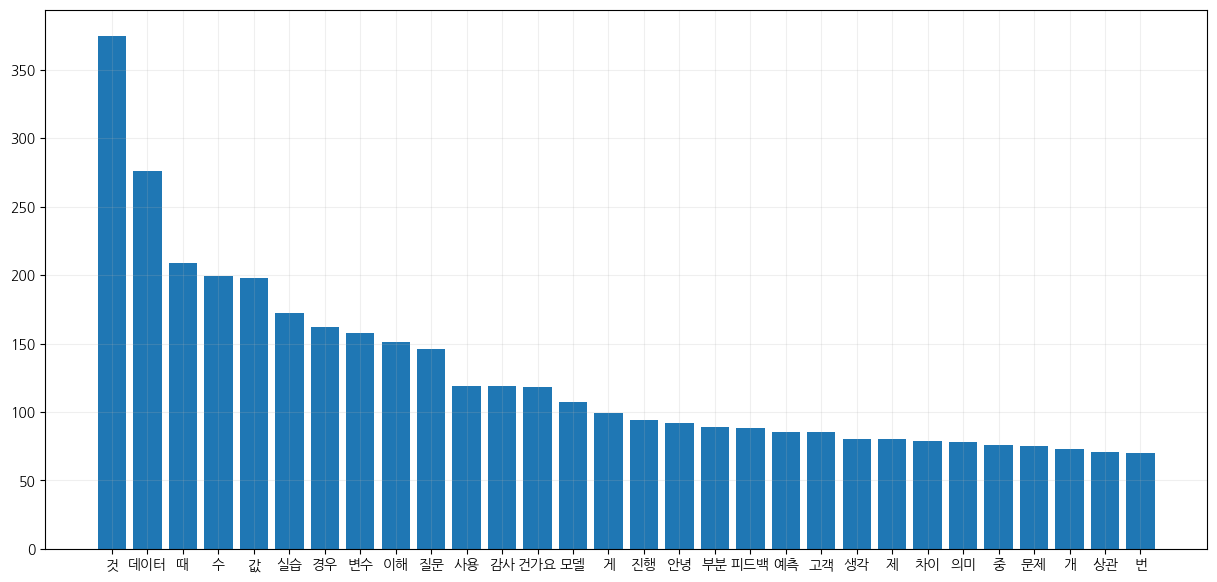

--------------------워드 클라우드--------------------------------
#######################################################################
--------------------데이터 확인-------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 8 to 3695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    488 non-null    object
 1   label   488 non-null    object
dtypes: object(2)
memory usage: 11.4+ KB
데이터 형태: None
--------------------길이-------------------------------
최소: 12  최대:  2655
타입: <class 'int'>
최대 길이 문서 인덱스: 163
최소 길이 문서 인덱스: 59
최대 길이 문서 내용: import collections
import re
a=list(input()) # 반복시킬 문자열 받기
b= input() # 목적
c=0 # 반복 횟수
y = [] # 반복할 문자열 갯수 
f = str(a[0]+'+'+a[1]+'+'+a[2]+'+') 

z = re.findall(f, b) 
z = list(str(z)) # z는 반복 대상 문자열
for i in z:
    if i in a:
        y.append(i)   # z중 '' ','등 불필요 문자 제거, 
        
if a[0]==a[1]==a[2]: # 반복시킬 문자열이 모두 같을 때
    d1=collections.Counter(a) # a 문자열 갯수
    

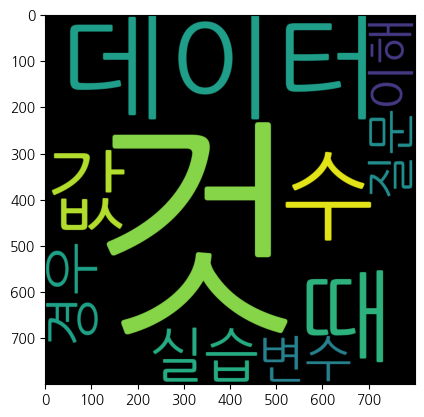

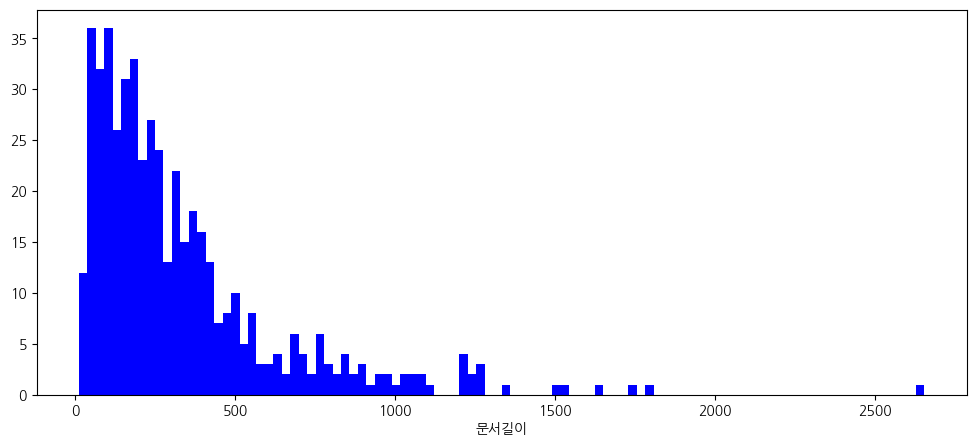

-------------------- 명사 추출 -------------------------------
--------------------단어별 빈도수-------------------------------
{'문제': 266, '값': 244, '수': 239, '입력': 237, '출력': 216, '코드': 203, '번': 179, '것': 166, '때': 151, '경우': 149, '문': 138, '질문': 123, '케이스': 116, '제': 115, '감사': 99, '안녕': 97, '리스트': 95, '부분': 92, '결과': 79, '코딩': 79, '개': 79, '학생': 77, '사용': 71, '함수': 67, '이해': 61, '중': 61, '상': 60, '방법': 59, '명': 59, '줄': 56, '다음': 55, '작성': 54, '실행': 51, '위': 51, '오류': 51, '생각': 50, '점': 50, '이': 48, '해당': 46, '일': 44, '이유': 43, '예제': 43, '마지막': 43, '건지': 42, '설명': 41, '숫자': 41, '배열': 41, '확인': 41, '답변': 41, '아래': 41, '건가요': 41, '하나': 41, '첨부': 40, '추가': 40, '채점': 40, '조건': 38, '테스트': 38, '개수': 36, '문자': 35, '관련': 34, '실패': 34, '문자열': 33, '무엇': 33, '거': 33, '점수': 33, '변수': 32, '이상': 31, '식': 31, '예시': 31, '커트라인': 30, '가능': 30, '마스터스': 29, '요소': 29, '후': 28, '정수': 28, '차원': 28, '데': 27, '실습': 27, '답': 26, '반복': 26, '어디': 25, '여기': 25, '정답': 24, '시': 24, '예': 24, '최대': 24, '해결': 24, '수정': 23, 

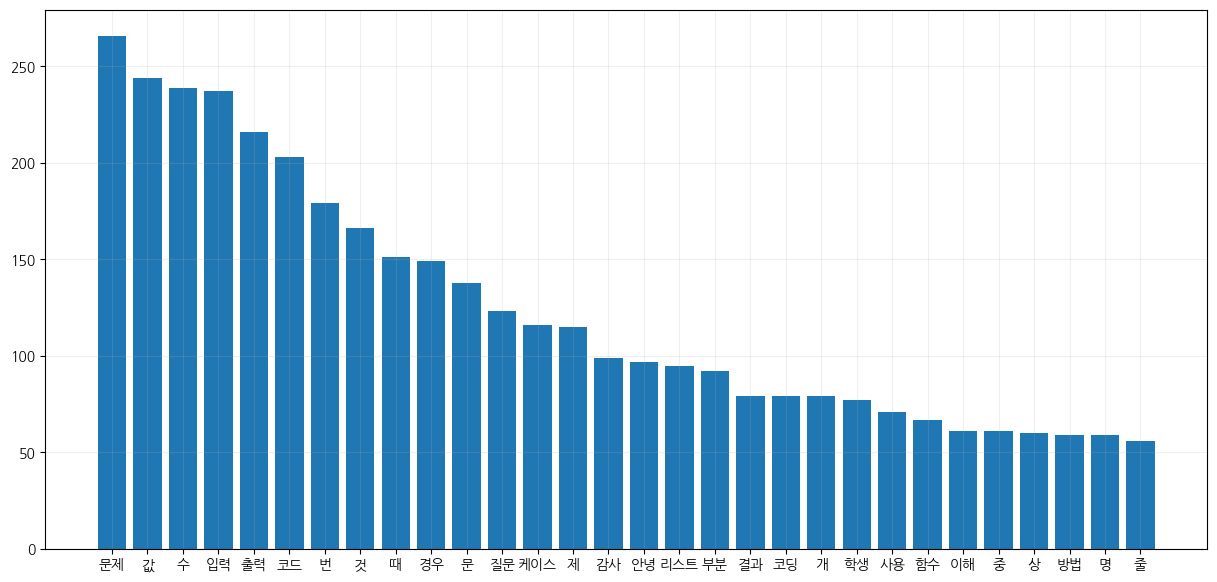

--------------------워드 클라우드--------------------------------
#######################################################################
--------------------데이터 확인-------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 0 to 3701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1097 non-null   object
 1   label   1097 non-null   object
dtypes: object(2)
memory usage: 25.7+ KB
데이터 형태: None
--------------------길이-------------------------------
최소: 13  최대:  6012
타입: <class 'int'>
최대 길이 문서 인덱스: 760
최소 길이 문서 인덱스: 756
최대 길이 문서 내용: sns.kdeplot(x = td[var])
plt.show()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
 in 
----&gt; 1 sns.kdeplot(x = td[var])
      2 plt.show()

~\anaconda3\lib\site-packages\seaborn\_decorators.py in inner_f(*args, **kwargs)
     44             )
     45       

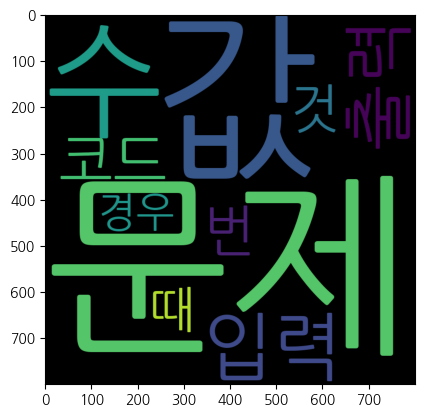

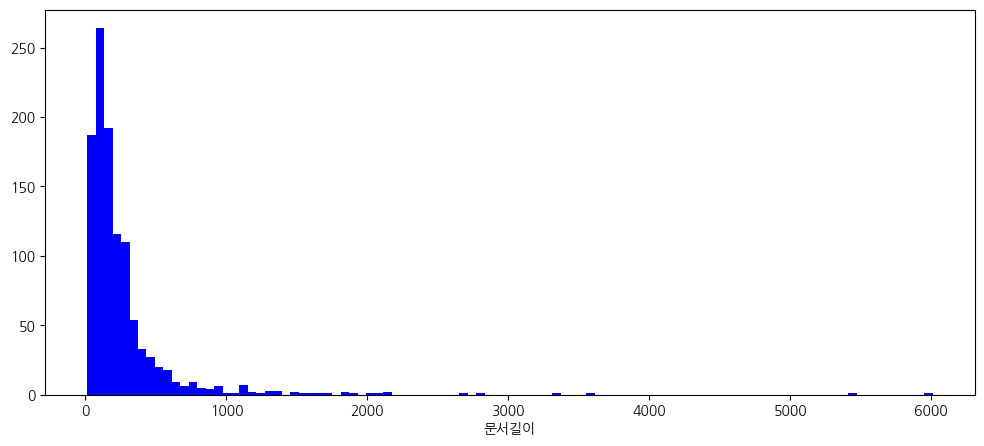

-------------------- 명사 추출 -------------------------------
--------------------단어별 빈도수-------------------------------
{'데이터': 405, '코드': 336, '값': 303, '것': 280, '오류': 253, '수': 251, '때': 195, '문제': 186, '부분': 173, '에러': 170, '모델': 169, '사용': 168, '파일': 166, '번': 161, '확인': 147, '실습': 145, '실행': 144, '진행': 143, '건가요': 131, '감사': 131, '질문': 125, '결과': 122, '개': 120, '변수': 115, '방법': 112, '안녕': 112, '열': 111, '위': 109, '시간': 107, '발생': 105, '프레임': 98, '중': 96, '후': 92, '경우': 90, '결': 89, '학습': 89, '문': 89, '측': 88, '작성': 87, '해결': 86, '제거': 86, '아래': 83, '이해': 81, '해당': 80, '게': 77, '과정': 72, '제': 72, '이유': 71, '시': 71, '걸까요': 71, '저장': 70, '이미지': 69, '무엇': 69, '전처리': 68, '분석': 67, '추가': 67, '이용': 64, '강사': 61, '입력': 61, '출력': 60, '거': 60, '설정': 59, '변경': 58, '함수': 58, '첨부': 58, '이': 58, '선언': 57, '사진': 56, '평균': 55, '의미': 55, '지정': 54, '여기': 51, '건지': 51, '그래프': 51, '자치구': 51, '이상': 50, '분': 49, '다음': 48, '행': 46, '기준': 46, '식': 45, '변환': 45, '예측': 44, '데': 43, '생성': 43, '수정': 42, '이동':

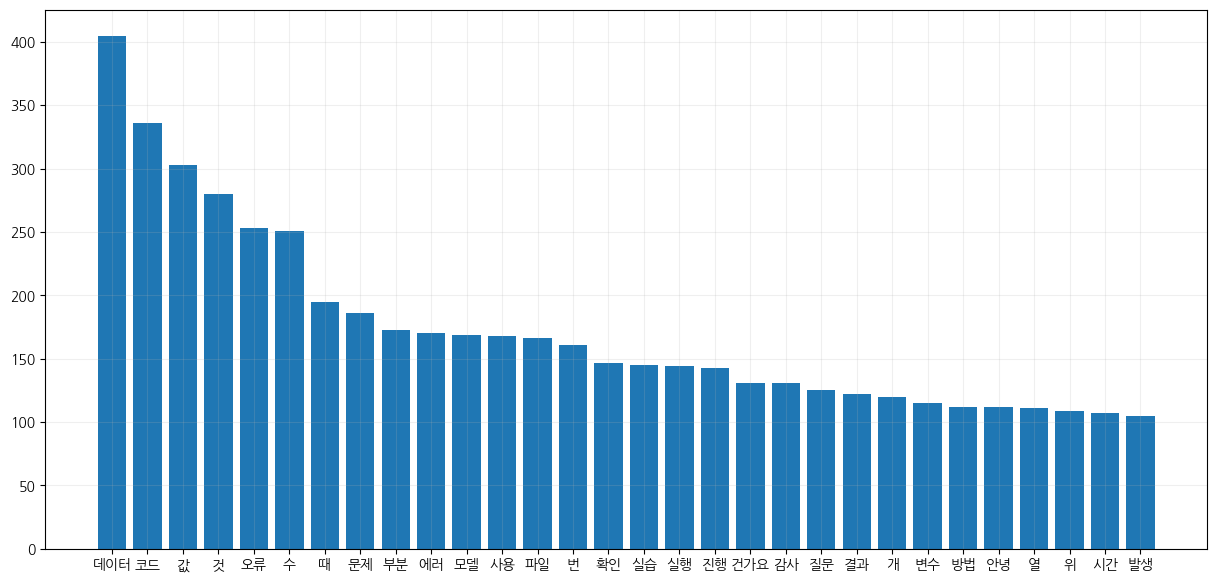

--------------------워드 클라우드--------------------------------
#######################################################################


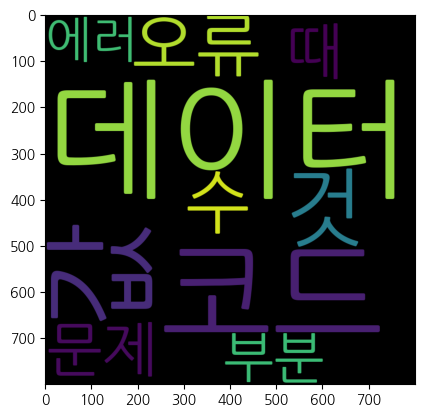

In [ ]:
for label in sorted(train_df.label.unique()):
    text_analysis(train_df,label)

# 단계2 : 데이터 전처리
> * Tokenization(Konlpy...)
> * Vectorization(N-grams, Sequence)
> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-3)

## 5. 데이터 준비
### 5-1. label 아래 형식으로 처리
```python
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}
```

In [ ]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

In [ ]:
train_df['label'].map(label_dict)

0       0
1       1
2       0
3       0
4       0
       ..
3701    0
3702    3
3703    2
3704    4
3705    2
Name: label, Length: 3706, dtype: int64

### 5-2. Train Validation split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
train_df['text']

0       self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...
1       현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...
2       glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...
3       tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...
4       filename = TEST_IMAGE + str(round(frame_sec)) ...
                              ...                        
3701    토큰화 이후 train val 를 분리하고 각 train set, val set에 ...
3702    올린 값들 중 최고점인 건가요? 아니면 최근에 올린 파일로 무조건 갱신인가요?\n최...
3703    수업에서 cacoo랑 packet tracer를 배우는 이유가\n\n1. IT 인프...
3704    inplace =True 해도 값이 변경이 안되고 none으로 뜹니다. 혹시 원격지...
3705    상관관계는 그렇게 크지 않게 나오는데 p -value 값은 관련이 있게 나오는데 \...
Name: text, Length: 3706, dtype: object

In [ ]:
x = train_df['text'].copy()

In [ ]:
y = train_df['label'].map(label_dict)

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
train_x.head()

1281    기억이 잘 나질 않아 궁금해서 질문드립니다.\n\n1. 처음 데이터를 x, y로 분...
507     ping test 해보았는데 정말 끊겨있네요 ㅠㅠ virtual box 네트워크 확...
7       범주형 데이터와 숫자형 데이터 설명해주신 내용 잘 읽었습니다. 계속 읽고 적응해나아...
2086    카시트 회귀분석을 위한 과정에서 가변수화를 하게 되는데, 이때 교육 수준은 왜 가변...
2832    제가 질문을 모호하게 해서 헷갈리게  해드린것 같습니다 ㅜㅜ\n제가 궁금했던 부분은...
Name: text, dtype: object

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/test.csv')

In [ ]:
test

,id,text
0,0,팀즈는 노트북으로 접속하고 강의는 데스크톱 이용하려고 하는데 문제는 없을까요? 이...
1,1,"셀프테스트에서 받은 점수가 해당 교육을 이수하고, 취업 연계등을 하는데 있어서 영향..."
2,2,a= int(input('정수 A의 값을 입력하시오.:'))\nb= int(inpu...
3,3,"def max4(a,b,c,d):\n maximum = a\n if b&..."
4,4,i**=2 가 i **=2 와 왜 같은지가 이해가 잘 안됩니다!!
...,...,...
924,924,aice특강 ppt는 따로 안올려주시나요?
925,925,안녕하세요~!\n실습 중 궁금한 점이 있어 문의 드립니다. \n\n1. 라벨 인코더...
926,926,안녕하세요.\nkT AIDU에서 전에 Associate 시험에 대해 공부할 수 있는...
927,927,app 마다 urls.py 을 만들어서 관리하는게 더 좋은 코드인가요?\n아니면 s...


In [ ]:
test_x = test['text']

In [ ]:
test_x.shape

(929,)

## 6. 데이터 처리

### 6-1. 특수문자 제거(Optional)
- [정규표현식 이용](https://docs.python.org/3/howto/regex.html)

In [ ]:
import string, re
punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

def strip_punc(corpus):
    return punc_regex.sub(' ', corpus)

In [ ]:
re.sub(r'\s+', ' ', strip_punc(train_x.iloc[1]).replace('\n',''))

'ping test 해보았는데 정말 끊겨있네요 ㅠㅠ virtual box 네트워크 확인 하긴 했는데 어떤 부분이 잘 못 되어있는지는 잘 모르겠습니다 원격으로 도와주시면 감사하겠습니다 '

In [ ]:
for i in range(len(train_x)):
    train_x.iloc[i] = re.sub(r'\s+', ' ', strip_punc(train_x.iloc[i]).replace('\n',''))
for i in range(len(val_x)):
    val_x.iloc[i] = re.sub(r'\s+', ' ', strip_punc(val_x.iloc[i]).replace('\n',''))
for i in range(len(test_x)):
    test_x.iloc[i] = re.sub(r'\s+', ' ', strip_punc(test_x.iloc[i]).replace('\n',''))

<ipython-input-46-f547cd97ffa8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x.iloc[i] = re.sub(r'\s+', ' ', strip_punc(test_x.iloc[i]).replace('\n',''))


In [ ]:
'''mecab = MeCab()
nouns_and_alpha = []

for sentence in train_df['text']:
    cleaned_sentence = re.sub(r'[^가-힣a-zA-Z\s]', '', sentence)
    nouns_and_alpha.extend([word for word, pos in mecab.pos(cleaned_sentence) if pos in ['NNG', 'NNP', 'SL', 'SN', 'SH', 'SN', 'SL', 'SN', 'SL', 'SH', 'SN']])

unique_nouns_and_alpha = list(set(nouns_and_alpha))'''

### 6-2. N-grams (sklearn)
> * [scikit-learn working with text data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#)
> * [scikit-learn text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
> * [한글 자료](https://datascienceschool.net/03%20machine%20learning/03.01.03%20Scikit-Learn%EC%9D%98%20%EB%AC%B8%EC%84%9C%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EA%B8%B0%EB%8A%A5.html)

In [ ]:
mecab.nouns(train_x[1])

['이미지',
 '개',
 '업로드',
 '자바',
 '스크립트',
 '동적',
 '폼',
 '개',
 '생성',
 '데',
 '클릭',
 '뭘',
 '수',
 '기본',
 '예제',
 '코드',
 '이유',
 '뭘까요']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
corpus_train = list(train_x)
corpus_val = list(val_x)
corpus_test = list(test_x)
count_vectorizer = CountVectorizer(tokenizer= mecab.nouns)
x_tr_counts = count_vectorizer.fit_transform(corpus_train)
x_val_counts = count_vectorizer.transform(corpus_val)
x_test_counts = count_vectorizer.transform(corpus_test)

In [ ]:
transformer = TfidfTransformer()
x_tr_tfidf = transformer.fit_transform(x_tr_counts)
x_val_tfidf = transformer.transform(x_val_counts)
x_test_tfidf = transformer.transform(x_test_counts)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=mecab.nouns)
x_tr_tfidfv = tfidf_vectorizer.fit_transform(corpus_train)
x_val_tfidfv = tfidf_vectorizer.transform(corpus_val)
x_test_tfidfv = tfidf_vectorizer.transform(corpus_test)

In [ ]:
print("Count Vectorizer Vocabulary size : ", len(count_vectorizer.vocabulary_))

Count Vectorizer Vocabulary size :  3089


In [ ]:
x_tr_tfidfv.toarray().sum()

8752.821838201233

In [ ]:
x_tr_tfidf.toarray().sum()

8752.821838201233

In [ ]:
mecab.nouns(train_x.iloc[0])

['기억', '질문', '처음', '데이터', '분할', '때', '뒤', '이유', '가요']

### 6-3. Sequence (keras, whatever)
> * [keras text classification](https://keras.io/examples/nlp/text_classification_from_scratch/)
> * [tensorflow text classification](https://www.tensorflow.org/tutorials/keras/text_classification)
* tokenizer.fit_on_texts() : 주어진 텍스트 데이터에 대해 단어 사전 생성
* 문장 길이 분포 살펴보기
* 문장 길이를 구해서 기초통계량, histogram, boxplot을 그려보고 적절한 개수를 결정합니다.
* tokenizer.texts_to_sequences() : 주어진 텍스트 데이터를 정수 시퀀스로 변환

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from keras.preprocessing import sequence
from keras.preprocessing import text
TOP_K = len(tfidf_vectorizer.vocabulary_)
MAX_SEQUENCE_LENGTH = 75

In [ ]:
x_mor_train = [mecab.nouns(train_x.iloc[i]) for i in range(len(train_x))]
x_mor_val = [mecab.nouns(val_x.iloc[i]) for i in range(len(val_x))]
x_mor_test = [mecab.nouns(test_x.iloc[i]) for i in range(len(test_x))]
x_mor_train_string = [" ".join(mecab.nouns(train_x.iloc[i])) for i in range(len(train_x))]
x_mor_val_string = [" ".join(mecab.nouns(val_x.iloc[i])) for i in range(len(val_x))]
x_mor_test_string = [" ".join(mecab.nouns(test_x.iloc[i])) for i in range(len(test_x))]

In [ ]:
x_mor_train_string

['기억 질문 처음 데이터 분할 때 뒤 이유 가요',
 '네트워크 확인 부분 원격 감사',
 '범주 데이터 숫자 데이터 설명 내용 적응 아래 첨부 파일 실습 데이터 서울시 릉 시간 비 데이터 저 데이터 범주 데이터 생각 제 의도 값 시간 대별 비 과 방법 사용 출력 의도 대로 질문 변량 분석 변량 분석 아래 가설 검증 방향 접근 방법 비 비 생각',
 '카시트 회귀분석 과정 가변 수화 이때 교육 수준 변수',
 '제 질문 것 부분 템플 릿 파일 위치 앱 내 파일 내 파일 처음 발견 끝 파일 건지 와중 조건 중복 파일 건지',
 '원격 수',
 '첨부 것 직선 정상 사용 여기 게 건가요 여기 오류',
 '강의 영상 오른쪽 밑 색 박스 강의 일부 때 이유',
 '동기식 처리 동기식 처리 비교 때 여행 준비 카페 예 직관 동기식 처리 우수 효율 비용 측면 고려 때 동기식 처리 유리 동기식 처리 사용 경우 경우',
 '안녕 제공 파일 실행 후 로그인 정상 입력 입력 해결 감사',
 '그래프 오류 이유 무엇 이전 문의 이용 문제 해결',
 '안녕 실습 파일 건 제공 스토리보드 템플 릿 슬라이드 추가 하나 파일 마지막 날 제출 건지 답변 감사',
 '콘 텐트 제 설정 건가요',
 '리스트 역순 출력 원소 수 입력 값 입력 리스트 역순 출력',
 '성별 성별 번 성 적용 값 연령 코드 연령 코드 대 대 대 대 대 대 대 대 연령 코드 작동 성별',
 '첨부 사진 번 고객 요구 사항 웹 서버 서비스 대 통합 제시 강사 인프라 구성도 사진 서버 복수 구성 거 인프라 구성 번호 번 이중화 때문 거 생각 고객 사 웹 서버 대 통합 이중화 웹 서버 사진 구성 건가요',
 '이전 강의 영상 중 학습 가능 기한 강의 시청 수 기한 연장 수 문',
 '도메인 관련 논문 검색 후 유의미 차 데이터 전처리 수업 의도 방법',
 '일 차 비게 프로젝트 주제 일 차 팀 플 일 차 진행 일 차 프로젝트 진행',
 '제 인 스턴스 볼륨 연결 사용 중',
 '히든 레이어 페이지 교안 추가 수정 게 

,count,mean,std,min,25%,50%,75%,max
0,2964.0,15.155196,13.874086,0.0,6.0,11.0,19.0,197.0


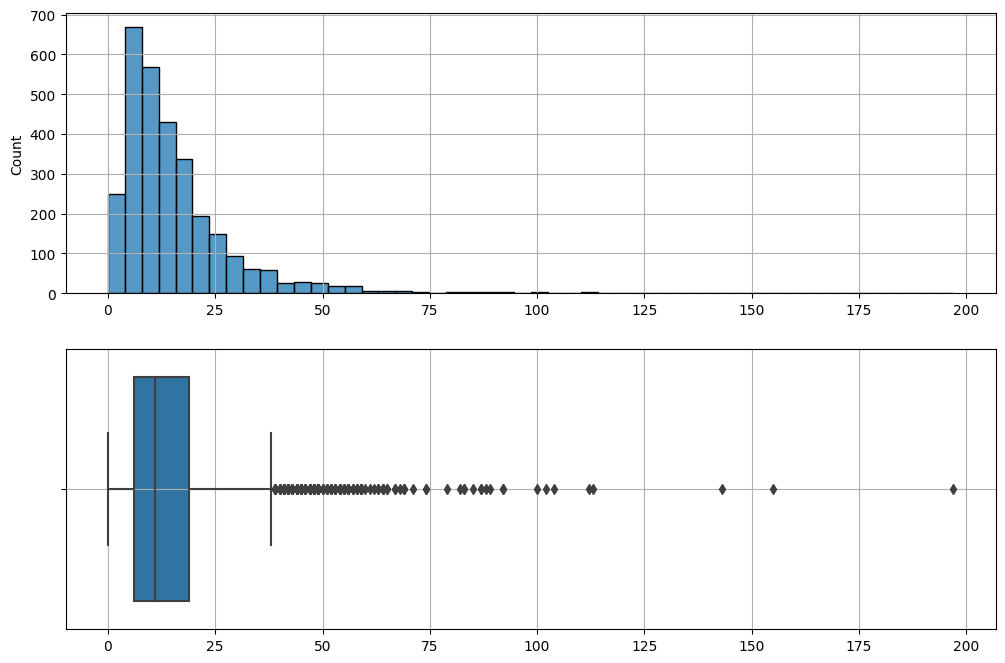

In [ ]:
train_word_counts = [len(x_mor_train[i]) for i in range(len(x_mor_train))]
display(pd.DataFrame(train_word_counts).describe().T)
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
sns.histplot(train_word_counts, bins=50)
plt.grid()
plt.subplot(2,1,2)
sns.boxplot(x=train_word_counts)
plt.grid()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(x_mor_train)
word_index = tokenizer.word_index
word_docs = tokenizer.index_docs
print(word_index)
print(word_docs)

{'것': 1, '수': 2, '값': 3, '데이터': 4, '때': 5, '문제': 6, '코드': 7, '실습': 8, '번': 9, '파일': 10, '안녕': 11, '부분': 12, '감사': 13, '오류': 14, '질문': 15, '문': 16, '사용': 17, '경우': 18, '진행': 19, '확인': 20, '입력': 21, '건가요': 22, '제': 23, '출력': 24, '실행': 25, '제출': 26, '중': 27, '개': 28, '이해': 29, '모델': 30, '변수': 31, '방법': 32, '결과': 33, '에러': 34, '후': 35, '시간': 36, '게': 37, '해결': 38, '해당': 39, '거': 40, '작성': 41, '추가': 42, '시': 43, '강사': 44, '이': 45, '발생': 46, '일': 47, '함수': 48, '위': 49, '부탁': 50, '첨부': 51, '생각': 52, '가능': 53, '걸까요': 54, '다음': 55, '건지': 56, '이유': 57, '설정': 58, '내용': 59, '학습': 60, '데': 61, '관련': 62, '설명': 63, '과정': 64, '강의': 65, '무엇': 66, '답변': 67, '분석': 68, '의미': 69, '하나': 70, '아래': 71, '사진': 72, '열': 73, '저장': 74, '예측': 75, '생성': 76, '이용': 77, '테스트': 78, '분': 79, '차이': 80, '이미지': 81, '어디': 82, '기준': 83, '코딩': 84, '접속': 85, '점': 86, '리스트': 87, '변경': 88, '제거': 89, '연결': 90, '이상': 91, '수정': 92, '식': 93, '여기': 94, '차': 95, '페이지': 96, '요청': 97, '프로젝트': 98, '상태': 99, '터': 100, '처리': 101, '케이스': 102

In [ ]:
x_mor_train_seq = tokenizer.texts_to_sequences(x_mor_train)
x_mor_val_seq = tokenizer.texts_to_sequences(x_mor_val)
x_mor_test_seq = tokenizer.texts_to_sequences(x_mor_test)

max_length = len(max(x_mor_train, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
    max_length = MAX_SEQUENCE_LENGTH

x_mor_train_seq = pad_sequences(x_mor_train_seq, maxlen=max_length)
x_mor_val_seq = pad_sequences(x_mor_val_seq, maxlen=max_length)
x_mor_test_seq = pad_sequences(x_mor_test_seq, maxlen=max_length)

In [ ]:
x_mor_test_seq.shape

(929, 75)

In [ ]:
tokenizer.word_counts

OrderedDict([('기억', 21),
             ('질문', 383),
             ('처음', 57),
             ('데이터', 608),
             ('분할', 21),
             ('때', 570),
             ('뒤', 67),
             ('이유', 145),
             ('가요', 57),
             ('네트워크', 39),
             ('확인', 329),
             ('부분', 413),
             ('원격', 77),
             ('감사', 410),
             ('범주', 50),
             ('숫자', 79),
             ('설명', 137),
             ('내용', 142),
             ('적응', 3),
             ('아래', 126),
             ('첨부', 154),
             ('파일', 458),
             ('실습', 496),
             ('서울시', 8),
             ('릉', 18),
             ('시간', 218),
             ('비', 9),
             ('저', 59),
             ('생각', 154),
             ('제', 303),
             ('의도', 9),
             ('값', 626),
             ('대별', 2),
             ('과', 51),
             ('방법', 239),
             ('사용', 370),
             ('출력', 286),
             ('대로', 35),
             ('변량', 24),
             (

In [ ]:
word_counts_freq = pd.Series(tokenizer.word_counts.values())

In [ ]:
word_counts_freq.describe()

count    3089.000000
mean       14.541923
std        49.492217
min         1.000000
25%         1.000000
50%         2.000000
75%         8.000000
max       867.000000
dtype: float64

In [ ]:
for i in range(1,20):
    print("{} 회 이상 나온 단어의 개수 : {}".format(i, word_counts_freq[word_counts_freq >= i].count()))

1 회 이상 나온 단어의 개수 : 3089
2 회 이상 나온 단어의 개수 : 1994
3 회 이상 나온 단어의 개수 : 1543
4 회 이상 나온 단어의 개수 : 1297
5 회 이상 나온 단어의 개수 : 1113
6 회 이상 나온 단어의 개수 : 963
7 회 이상 나온 단어의 개수 : 875
8 회 이상 나온 단어의 개수 : 795
9 회 이상 나온 단어의 개수 : 729
10 회 이상 나온 단어의 개수 : 672
11 회 이상 나온 단어의 개수 : 627
12 회 이상 나온 단어의 개수 : 604
13 회 이상 나온 단어의 개수 : 556
14 회 이상 나온 단어의 개수 : 529
15 회 이상 나온 단어의 개수 : 494
16 회 이상 나온 단어의 개수 : 480
17 회 이상 나온 단어의 개수 : 450
18 회 이상 나온 단어의 개수 : 430
19 회 이상 나온 단어의 개수 : 417


In [ ]:
# 3회 이상 나온 단어의 개수로 설정!!!
TOP_K = 1543

In [ ]:
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(x_mor_train)
word_index = tokenizer.word_index
word_docs = tokenizer.index_docs
print(word_index)
print(word_docs)

x_mor_train_seq = tokenizer.texts_to_sequences(x_mor_train)
x_mor_val_seq = tokenizer.texts_to_sequences(x_mor_val)
x_mor_test_seq = tokenizer.texts_to_sequences(x_mor_test)

max_length = len(max(x_mor_train, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
    max_length = MAX_SEQUENCE_LENGTH

x_mor_train_seq = pad_sequences(x_mor_train_seq, maxlen=max_length)
x_mor_val_seq = pad_sequences(x_mor_val_seq, maxlen=max_length)
x_mor_test_seq = pad_sequences(x_mor_test_seq, maxlen=max_length)

{'것': 1, '수': 2, '값': 3, '데이터': 4, '때': 5, '문제': 6, '코드': 7, '실습': 8, '번': 9, '파일': 10, '안녕': 11, '부분': 12, '감사': 13, '오류': 14, '질문': 15, '문': 16, '사용': 17, '경우': 18, '진행': 19, '확인': 20, '입력': 21, '건가요': 22, '제': 23, '출력': 24, '실행': 25, '제출': 26, '중': 27, '개': 28, '이해': 29, '모델': 30, '변수': 31, '방법': 32, '결과': 33, '에러': 34, '후': 35, '시간': 36, '게': 37, '해결': 38, '해당': 39, '거': 40, '작성': 41, '추가': 42, '시': 43, '강사': 44, '이': 45, '발생': 46, '일': 47, '함수': 48, '위': 49, '부탁': 50, '첨부': 51, '생각': 52, '가능': 53, '걸까요': 54, '다음': 55, '건지': 56, '이유': 57, '설정': 58, '내용': 59, '학습': 60, '데': 61, '관련': 62, '설명': 63, '과정': 64, '강의': 65, '무엇': 66, '답변': 67, '분석': 68, '의미': 69, '하나': 70, '아래': 71, '사진': 72, '열': 73, '저장': 74, '예측': 75, '생성': 76, '이용': 77, '테스트': 78, '분': 79, '차이': 80, '이미지': 81, '어디': 82, '기준': 83, '코딩': 84, '접속': 85, '점': 86, '리스트': 87, '변경': 88, '제거': 89, '연결': 90, '이상': 91, '수정': 92, '식': 93, '여기': 94, '차': 95, '페이지': 96, '요청': 97, '프로젝트': 98, '상태': 99, '터': 100, '처리': 101, '케이스': 102

In [ ]:
x_mor_train_seq.max()

1542

In [ ]:
x_mor_train_seq

array([[  0,   0,   0, ..., 134,  57, 157],
       [  0,   0,   0, ...,  12, 117,  13],
       [  0,   0,   0, ..., 673, 673,  52],
       ...,
       [  0,   0,   0, ..., 338,   2,   1],
       [  0,   0,   0, ...,  25,  19,   2],
       [  0,   0,   0, ...,  44, 843,  10]], dtype=int32)

### 6-4. Word2Vec (gensim, optional)
> * [gensim-word2vec-tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)
> * [tensorflow-word2vec-tutorial](https://www.tensorflow.org/tutorials/text/word2vec?hl=ko)

In [ ]:
# 아래 함수는 제공합니다.
def get_sent_embeddings(model, embedding_size, tokenized_words):

    # 단어 임베딩 및 n_words의 크기가 0인 feature_vec 배열을 0으로 초기화합니다.
    # 또한 model.wv.index2word를 사용하여 Word2Vec 모델의 어휘에 단어 세트를 생성합니다.
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)

    # 토큰화된 문장의 각 단어를 반복하고 Word2Vec 모델의 어휘에 존재하는지 확인합니다.
    # 그렇다면 n_words가 증가하고 단어의 임베딩이 feature_vec에 추가됩니다.
    for word in tokenized_words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    # Word2Vec 모델의 어휘에 있는 입력 문장에 단어가 있는지 확인합니다.
    # 있다면 feature_vec를 n_words로 나누어 입력 문장의 평균 임베딩을 구합니다.
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

def get_dataset(sentences, model, num_features):
    # 각 문장에 대한 임베딩을 보유할 dataset이라는 빈 목록을 초기화합니다.
    dataset = list()
    # 문장의 각 문장을 반복하고 앞에서 설명한 get_sent_embeddings() 함수를 사용하여 문장에 대한 평균 임베딩을 생성합니다.
    # 결과 문장 임베딩이 데이터 세트 목록에 추가됩니다.
    for sent in sentences:
        dataset.append(get_sent_embeddings(model, num_features, sent))

    # 루프에서 생성된 문장 임베딩을 sent_embedding_vectors라는 2차원 배열에 쌓습니다.
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

### 6-5. 데이터 저장하기
* N-gram, Sequence로 처리한 데이터 저장
* sparse data에 대해서는 scipy.sparse.save_npz 활용

In [ ]:
!pip install scipy

In [ ]:
import scipy

In [ ]:
train_x.to_csv('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/train_x.csv')
train_y.to_csv('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/train_y.csv')
val_x.to_csv('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/test_x.csv')
val_y.to_csv('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/test_y.csv')
test_x.to_csv('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/test_x.csv')

In [ ]:
print(x_tr_tfidf.shape)
print(x_val_tfidf.shape)

(2964, 3089)
(742, 3089)


In [ ]:
scipy.sparse.save_npz('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/x_train_tfidf', x_tr_tfidf)
scipy.sparse.save_npz('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/x_val_tfidf', x_val_tfidf)
scipy.sparse.save_npz('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/x_test_tfidf', x_test_tfidf)

In [ ]:
print(x_mor_train_seq.shape)
print(x_mor_test_seq.shape)

(2964, 75)
(742, 75)


In [ ]:
np.save( '/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/x_mor_seq_train',x_mor_train_seq)
np.save( '/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/x_mor_seq_val',x_mor_val_seq)
np.save( '/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/x_mor_seq_test',x_mor_test_seq)

-- 10/18 로드 테스트

In [ ]:
n = np.load('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/n_gram_mecab_metrix_train.npy')
n

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
n = np.load('/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/sequence_metrix_word10000_train.npy')
n

array([[   0,    0,    0, ..., 2438,  187,  924],
       [   0,    0,    0, ..., 1059, 2439,  249],
       [   0,    0,    0, ..., 4267, 5723, 2443],
       ...,
       [   0,    0,    0, ..., 3210,   40,  106],
       [   0,    0,    0, ...,  311, 1978,   26],
       [   0,    0,    0, ...,  566, 2229, 5048]], dtype=int32)

In [ ]:
import joblib

joblib.dump(word_index, '/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/word_index.pkl')

['/content/drive/MyDrive/2023.10.16_미니프로젝트4차_실습자료/word_index.pkl']